# Logistička regresija

### Predviđanje da li cena BTC raste/opada na kraju dana korišćenjem modela Logističke regresije

**Koraci:**

1. Učitavanje i pretprocesiranje podataka
2. Filtriranje kolona
3. Kreiranje potrebnih kolona koje prezentuju pad/rast cene
4. Podela skupa podataka
5. Određivanje ciljne promenljive
6. Skaliranje
7. Kreiranje i treniranje modela
8. Predviđanje modela
9. Izračunavanje tačnosti
10. Izračunavanje matrice konfuzije
11. Generisanje klasifikacionog izveštaja
12. Analiza sigurnosti klasifikatora

### Učitavanje biblioteka

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

%run 02_Preprocessing_and_data_analysis.ipynb
#%run 03_Utility_functions.ipynb

### Učitavanje i pretprocesiranje skupa podataka

In [5]:
data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [6]:
# Dimenzije skupa podataka

data.shape

(3613769, 9)

### Filtriranje kolona

In [7]:
data_ = data.drop(['Volume_(BTC)','Volume_(Currency)','Weighted_Price'], axis=1)
data_.head()

,Timestamp,Open,High,Low,Close,Date
0,1325317920,4.39,4.39,4.39,4.39,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,2012-01-01


### Dodavanje kolone sa indeksom

In [8]:
#data_["row_id"] = range(1, len(data_) + 1)

In [9]:
#data_.set_index('row_id', inplace=True)
#data_.head()

### Razlika vrednosti na otvaranju i vrednosti na zatvaranju

In [10]:
# Dodavanje novog atributa (kolone) 'pos_neg' koji
# predstavlja razliku otvarajuce i zatvarajuce
# vrednosti (cene) bitkoina za taj dan

data_['pos_neg'] = data_['Close']-data_['Open']
data_.head()

# Na osnovu prethodno dodatog atributa, moze se
# videti da li se instanca, odnosno dan zatvorio
# sa porastom vrednosti ili sa padom vrednosti

,Timestamp,Open,High,Low,Close,Date,pos_neg
0,1325317920,4.39,4.39,4.39,4.39,2011-12-31,0.00
478,1325346600,4.39,4.39,4.39,4.39,2011-12-31,0.00
547,1325350740,4.50,4.57,4.50,4.57,2011-12-31,0.07
548,1325350800,4.58,4.58,4.58,4.58,2011-12-31,0.00
1224,1325391360,4.58,4.58,4.58,4.58,2012-01-01,0.00


### Računanje indikatora up/down

In [11]:
# Dodavanje novog atributa 'Up/Down' koji ce biti
# ciljna (target) promenljiva - koju treba predvideti

# Atribut 'Up/Down' je binarna kolona cije vrednosti
# mogu biti:
# 0 = gubitak (pad cene)
# 1 = dobitak (rast cene)

data_['Up/Down'] = np.where(data_['pos_neg']>0, 1, 0)
data_.tail()

,Timestamp,Open,High,Low,Close,Date,pos_neg,Up/Down
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,2021-03-30,-28.31,0
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,2021-03-30,1.84,1
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,2021-03-30,30.41,1
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,2021-03-30,18.41,1
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2021-03-31,10.43,1


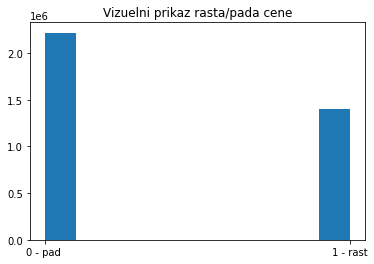

In [12]:
# Vizuelni prikaz rasta/pada cene

plt.title('Vizuelni prikaz rasta/pada cene')
plt.hist(data_['Up/Down'])
plt.xticks(np.arange(0, 2), ['0 - pad ', '1 - rast'], rotation='horizontal')

plt.show()

In [13]:
data_ = data_.drop('Timestamp',axis=1)
data_.head()

,Open,High,Low,Close,Date,pos_neg,Up/Down
0,4.39,4.39,4.39,4.39,2011-12-31,0.00,0
478,4.39,4.39,4.39,4.39,2011-12-31,0.00,0
547,4.50,4.57,4.50,4.57,2011-12-31,0.07,1
548,4.58,4.58,4.58,4.58,2011-12-31,0.00,0
1224,4.58,4.58,4.58,4.58,2012-01-01,0.00,0


In [14]:
# data_.shape

### Podela skupa podataka na skup za treniranje i skup za testiranje u datoj razmeri

In [15]:
train, test = data_split(data_, test_size = 0.2)

### Odredjivanje ciljne promenljive

In [16]:
# Skup atributa

X_train = train[['Open', 'High', 'Low','Close']]
X_test = test[['Open', 'High', 'Low','Close']]


# Ciljna promenljiva

y_train = train['Up/Down']
y_test = test['Up/Down']

In [17]:
# Dimenzije vektora ciljnih promenljivih
# na skupu za treniranje i skupu za testiranje

# y_train.shape, y_test.shape

### Broj nula i jedinica u skupovima za trening i test

In [18]:
non_zero_train = np.count_nonzero(y_train, axis=0) # ne-nula
zero_train = y_train.shape[0] - non_zero_train # nula
print('Jedinice u trening skupu: ', non_zero_train, '\nNule u trening skupu: ', zero_train)

Jedinice u trening skupu:  1052371 
Nule u trening skupu:  1838645


In [19]:
non_zero_test = np.count_nonzero(y_test, axis=0) # ne-nula
zero_test = y_test.shape[0] - non_zero_test # nula
print('Jedinice u test skupu: ', non_zero_test, '\nNule u test skupu: ', zero_test)

Jedinice u test skupu:  344497 
Nule u test skupu:  378256


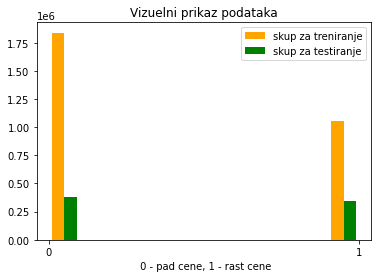

In [20]:
# Vizuelni prikaz nula i jedinica u trening i test skupu

plt.title("Vizuelni prikaz podataka")
plt.xticks([0,1])
plt.xlabel(' 0 - pad cene, 1 - rast cene')
plt.hist([y_train, y_test], color=['orange', 'green'], label=['skup za treniranje', 'skup za testiranje'])
plt.legend(loc='best')
plt.show()

### Skaliranje

In [21]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Kreiranje i treniranje modela

In [22]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

### Predvidjanje modela

In [23]:
predictions = logmodel.predict(X_test)
train_predictions = logmodel.predict(X_train)

In [24]:
# predictions, train_predictions

### Tačnost na skupovima za treniranje i testiranje

In [25]:
train_score = metrics.accuracy_score(y_train, train_predictions)
test_score = metrics.accuracy_score(y_test, predictions)
print("Tacnost na skupu za treniranje: {train}\nTacnost na skupu za testiranje: {test}".format(train=train_score, test=test_score))

Tacnost na skupu za treniranje: 0.650886055282987
Tacnost na skupu za testiranje: 0.5503138693301861


### Ostale mere na skupu za testiranje

In [26]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.56      0.64      0.60    378256
           1       0.53      0.45      0.49    344497

    accuracy                           0.55    722753
   macro avg       0.55      0.55      0.54    722753
weighted avg       0.55      0.55      0.55    722753



### Matrica konfuzije

In [27]:
confusion_m = metrics.confusion_matrix(y_test, predictions)
confusion_m

array([[242463, 135793],
       [189219, 155278]], dtype=int64)

In [28]:
tp = confusion_m[0][0]
tp

242463

In [29]:
fp = confusion_m[0][1]
fp

135793

In [30]:
fn = confusion_m[1][0]
fn

189219

In [31]:
tn = confusion_m[1][1]
tn

155278

### Analiza sigurnosti klasifikatora

In [32]:
first_ten_predictions = predictions[0:10]
first_ten_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
# verovatnoce da instance pripadaju pozitivnoj odnosno negativnoj klasi

predictions_probabilities = logmodel.predict_proba(X_test)
predictions_probabilities[0:10]

array([[0.53501154, 0.46498846],
       [0.53230878, 0.46769122],
       [0.54261328, 0.45738672],
       [0.54069549, 0.45930451],
       [0.53195387, 0.46804613],
       [0.53263856, 0.46736144],
       [0.54002982, 0.45997018],
       [0.53513254, 0.46486746],
       [0.54232094, 0.45767906],
       [0.52792151, 0.47207849]])

In [34]:
logmodel_confidence = []

for p in predictions_probabilities: 
    logmodel_confidence.append(np.abs(p[0]-p[1]))
    
logmodel_confidence = np.array(logmodel_confidence)

In [35]:
# indeksi instanci uredjeni na osnovu sigurnosti klasifikatora u svoju odluku
# pocev od indeksa instanci oko cije klasifikacije je klasifikator najmanje siguran

logmodel_confidence.argsort()

array([383447, 421242, 412921, ..., 670425, 670428, 671558], dtype=int64)

In [36]:
# uredjeni niz razlike verovatnoca pocev od onih koji se
# najmanje razlikuju ka onim koji se najvise razlikuju

logmodel_confidence.sort()
logmodel_confidence

array([4.45709959e-07, 7.36806294e-07, 1.10580627e-06, ...,
       9.99725159e-01, 9.99728072e-01, 9.99767142e-01])